# Import necassary libraries

In [1]:
import numpy as np
import pandas as pd
import os
import torch
import wandb
import ast
import re
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
torch.cuda.is_available()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

# Retrieve dataset and prepare it for the model

Index(['Unnamed: 0', 'names', 'contents', 'classIndex'], dtype='object')
Index(['contents', 'classIndex'], dtype='object')
[0 1 2]


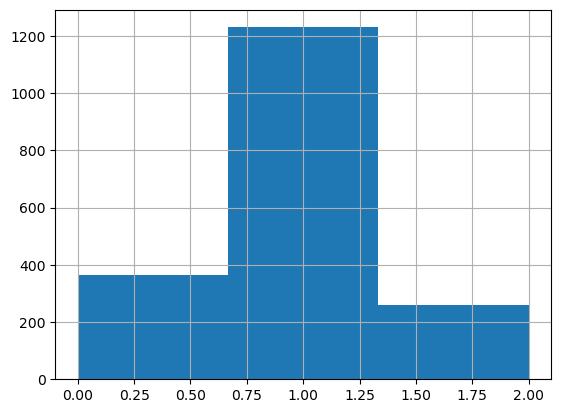

In [2]:
classesList = ['andere','factuur','aanmaning']

Dataset = pd.read_csv(os.getcwd() + "\\test_extraction_emails.csv")
Dataset['classIndex'].hist(bins=3)
print(Dataset.columns)
Dataset = Dataset.drop(['Unnamed: 0','names'],axis=1)
print(Dataset.columns)

def reducedDataset(dataset):
    dataset = dataset.drop(dataset[dataset['classIndex'] == 0].index,axis=0)
    dataset.loc[dataset['classIndex'] == 1, 'classIndex'] = 0
    dataset.loc[dataset['classIndex'] == 2, 'classIndex'] = 1
    return dataset

#Dataset = reducedDataset(Dataset)

print(Dataset['classIndex'].unique())

### Split dataset into train/val/test set

In [3]:
trainSet, evalSet = train_test_split(Dataset, test_size=0.25, stratify=Dataset['classIndex'], random_state=42)
valSet, testSet = train_test_split(evalSet, test_size=0.4, stratify=evalSet['classIndex'], random_state=42)

### Define helper functions and variables

In [4]:
#check if CUDA capable gpu is available
cudaAvailable = torch.cuda.is_available()

def calculate_class_weights(trainingDataset):
    weightList = []
    numberOfLabels = len(trainingDataset['classIndex'].unique())
    for i in range(0,numberOfLabels):
        weight = len(trainingDataset.index) / (numberOfLabels * len(trainingDataset[trainingDataset['classIndex'] == i].index))
        weightList.append(weight)
    print(weightList)
    return weightList

# Define model/sweep and start training

In [9]:
sweepConfig = {'method' : 'grid', 'parameters' : {'num_train_epochs' : {'min' : 3, 'max' : 5}, 'learning_rate' : {'values' : [4e-5,5e-5,6e-5]}, 'train_batch_size' : {'values' : [16,32]}}}
sweepID = wandb.sweep(sweepConfig, project='Test sweep')

def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

def train():
    wandb.init()
    trainArgumentsSweep = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'wandb_project' : 'Test sweep'}
    classifierSweep = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(trainSet['classIndex'].unique()),args=trainArgumentsSweep, use_cuda=True, weight=calculate_class_weights(trainSet), sweep_config=wandb.config)
    classifierSweep.train_model(trainSet)
    result, model_outputs, wrong_predictions = classifierSweep.eval_model(testSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
    wandb.log({'mcc' : result['mcc'], 'f1' : result['f1'], 'confusion_matrix' : result['confusionMatrix']})
    wandb.join()
    
wandb.agent(sweepID, train)

Create sweep with ID: ubozjgk2
Sweep URL: https://wandb.ai/spacehack100/Test%20sweep/sweeps/ubozjgk2


wandb: Agent Starting Run: 8yeu4moh with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▇█▁▄▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▅▃▁
mcc,▁
Training loss,0.00884
f1,0.92617
global_step,250
lr,0.0
mcc,0.74001


wandb: Agent Starting Run: xdr99ovr with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁
f1,▁
global_step,▁█
lr,█▁
mcc,▁
Training loss,0.01037
f1,0.92617
global_step,100
lr,1e-05
mcc,0.75659


wandb: Agent Starting Run: zc1k9gcb with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▅▂▃█▁▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.00056
f1,0.9396
global_step,300
lr,0.0
mcc,0.78733


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5w98rgf9 with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▄▁
f1,▁
global_step,▁▅█
lr,█▄▁
mcc,▁
Training loss,0.00239
f1,0.94631
global_step,150
lr,0.0
mcc,0.80557


wandb: Agent Starting Run: e0csvlnq with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▃█▁▁▁▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00022
f1,0.9396
global_step,400
lr,0.0
mcc,0.78244


wandb: Agent Starting Run: 0cjt8hyo with config:
wandb: 	learning_rate: 4e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▆▁▂█
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.32844
f1,0.9396
global_step,200
lr,0.0
mcc,0.78244


wandb: Agent Starting Run: 6pbc0up4 with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▅▃▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▄▃▁
mcc,▁
Training loss,0.00166
f1,0.92617
global_step,250
lr,0.0
mcc,0.7335


wandb: Agent Starting Run: 7d3afrkt with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁
f1,▁
global_step,▁█
lr,█▁
mcc,▁
Training loss,0.05132
f1,0.92617
global_step,100
lr,1e-05
mcc,0.74777


wandb: Agent Starting Run: gj0zrurw with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁▂▁▂▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.00117
f1,0.93289
global_step,300
lr,1e-05
mcc,0.75267


wandb: Agent Starting Run: pyve8t1o with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▄█▁
f1,▁
global_step,▁▅█
lr,█▄▁
mcc,▁
Training loss,0.00229
f1,0.91275
global_step,150
lr,1e-05
mcc,0.69268


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zv3yxrhw with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▂▃▁▁▆▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.0008
f1,0.93289
global_step,400
lr,0.0
mcc,0.75573


wandb: Agent Starting Run: x9vfe0pa with config:
wandb: 	learning_rate: 5e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▅▁▁█
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.12352
f1,0.94631
global_step,200
lr,0.0
mcc,0.80557


wandb: Agent Starting Run: uyo9o78v with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▇▁▁▁
f1,▁
global_step,▁▃▅▆█
lr,█▆▅▃▁
mcc,▁
Training loss,0.00201
f1,0.95302
global_step,250
lr,0.0
mcc,0.83139


wandb: Agent Starting Run: 8rjxlt40 with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 3
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁
f1,▁
global_step,▁█
lr,█▁
mcc,▁
Training loss,0.03543
f1,0.93289
global_step,100
lr,1e-05
mcc,0.76704


wandb: Agent Starting Run: qxs68y9d with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▅█▁▁▁▁
f1,▁
global_step,▁▂▄▅▇█
lr,█▇▅▄▂▁
mcc,▁
Training loss,0.00279
f1,0.95302
global_step,300
lr,1e-05
mcc,0.83017


wandb: Agent Starting Run: yedej7ik with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 4
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Running Epoch 0 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 4:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▇█▁
f1,▁
global_step,▁▅█
lr,█▅▁
mcc,▁
Training loss,0.17103
f1,0.94631
global_step,150
lr,1e-05
mcc,0.80557


wandb: Agent Starting Run: 5m4umfck with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 16


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/84 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,█▁▂▁▁▃▁▁
f1,▁
global_step,▁▂▃▄▅▆▇█
lr,█▇▆▅▄▃▂▁
mcc,▁
Training loss,0.00038
f1,0.95302
global_step,400
lr,0.0
mcc,0.83017


wandb: Agent Starting Run: ipjgiz5c with config:
wandb: 	learning_rate: 6e-05
wandb: 	num_train_epochs: 5
wandb: 	train_batch_size: 32


[0.6052393857271906, 2.875536480686695]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1340 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 1 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 2 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 3 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

Running Epoch 4 of 5:   0%|          | 0/42 [00:00<?, ?it/s]

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/149 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Training loss,▆▁▅█
f1,▁
global_step,▁▃▆█
lr,█▆▃▁
mcc,▁
Training loss,0.12713
f1,0.9396
global_step,200
lr,0.0
mcc,0.77935


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


### Move best result into sepperate model

In [5]:
wandb.init()
trainArguments = {'reprocess_input_data' : True, 'use_multiprocessing' : True, 'num_train_epochs' : 3, 'overwrite_output_dir' : True, 'use_early_stopping' : True, 'early_stopping_consider_epochs' : True, 'train_batch_size' : 16, 'optimizer' : 'AdamW', 'save_model_every_epoch' : False, 'logging_steps' : 25, 'learning_rate' : 6e-5, 'wandb_project' : 'Test seperate reduced', 'wandb_kwargs' : {'magic' : True}}
classifier = ClassificationModel("bert","GroNLP/bert-base-dutch-cased", num_labels=len(trainSet['classIndex'].unique()),args=trainArguments, use_cuda=True, weight=calculate_class_weights(trainSet))
classifier.train_model(trainSet)

wandb: Currently logged in as: spacehack100. Use `wandb login --relogin` to force relogin


[1.686060606060606, 0.5028922631959508, 2.3900343642611683]


Some weights of the model checkpoint at GroNLP/bert-base-dutch-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at GroNLP/bert-base

  0%|          | 0/1391 [00:00<?, ?it/s]

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/87 [00:00<?, ?it/s]

Running Epoch 1 of 3:   0%|          | 0/87 [00:00<?, ?it/s]

Running Epoch 2 of 3:   0%|          | 0/87 [00:00<?, ?it/s]

(261, 0.401064336496152)

### Evaluate the resulting model against validation set

In [6]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = classifier.eval_model(valSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/278 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/35 [00:00<?, ?it/s]

Training loss,▄▆█▂▃▃▁▂▁▁
global_step,▁▂▃▃▄▅▆▆▇█
lr,█▇▆▆▅▄▃▃▂▁
Training loss,0.01098
global_step,250
lr,0.0


wandb: WARNING wandb.plots.* functions are deprecated and will be removed in a future release. Please use wandb.plot.* instead.


{'mcc': 0.7127332602194065, 'f1': 0.8597122302158273, 'confusionMatrix': array([[ 40,  11,   3],
       [  3, 173,   9],
       [  4,   9,  26]], dtype=int64), 'eval_loss': 0.7471776382332401}


In [7]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 4, 'text_a': 'Met bijlage EVI DE GREVE BVBA LEO DE BETHUNELAAN AALST evidegrevegmailcom BTW Op ma sep om schreef Evi De Greve In bijlage Thomas zit jij vandaag nog achter de veren van de goedkeurders voor mijn eerdere facturen alsjeblieft Mijn laatst betaalde werkdag voor jullie is juli betaald op augustus maar sindsdien niks meer Evi EVI DE GREVE BVBA LEO DE BETHUNELAAN AALST evidegrevegmailcom BTW', 'text_b': None, 'label': 1}
<class 'dict'>


testSet_id  \
0            4   
1            6   
2           10   
3           16   
4           19   
5           24   
6           50   
7           51   
8           55   
9           83   
10          86   
11          88   
12          90   
13          98   
14         111   
15         113   
16         118   
17         142   
18         149   
19         150   
20         162   
21         167   
22         172   
23         185   
24         187   
25         193   
26         195   
27         201   
28         206   
29         218   
30         220   
31         222   
32         225   
33         231   
34         248   
35         258   
36         261   
37         269   
38         273   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Evaluate the resulting model against test set

In [8]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

result, model_outputs, wrong_predictions = classifier.eval_model(testSet, f1=f1_multiclass, confusionMatrix=confusion_matrix)
print(result)

C:\Users\jensk\miniconda3\envs\gpu\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/186 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/24 [00:00<?, ?it/s]

{'mcc': 0.711435488130277, 'f1': 0.8602150537634409, 'confusionMatrix': array([[ 26,  10,   1],
       [  6, 116,   1],
       [  1,   7,  18]], dtype=int64), 'eval_loss': 0.7474528474073546}


In [9]:
print(type(wrong_predictions[0]))
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = str(wrong_predictions[i])
    #wrong_predictions[i] = re.sub("'","\"",wrong_predictions[i])
print(type(wrong_predictions[0]))
print(wrong_predictions[0])
for i, x in enumerate(wrong_predictions):
    wrong_predictions[i] = ast.literal_eval(wrong_predictions[i])
print(type(wrong_predictions[0]))
wrong_predictions_df = pd.DataFrame(wrong_predictions)
wrong_predictions_df = wrong_predictions_df.rename(columns={'guid' : 'testSet_id', 'text_a' : 'text', 'text_b' : 'pred_label', 'label' : 'true_label'})
for i, row in wrong_predictions_df.iterrows():   
    wrong_predictions_df.iloc[i,2] = np.argmax(model_outputs[int(row['testSet_id'])])
wrong_predictions_df

<class 'simpletransformers.classification.classification_utils.InputExample'>
<class 'str'>
{'guid': 1, 'text_a': 'Geachte Heer Mevrouw In de bijlage vindt u een rekeningoverzicht vanaf Mocht u vragen hebben of heeft u kopien nodig van uw facturen u kunt ons altijd contacteren op het volgende adres cashbeneluxsappicom Wij willen u vriendelijk verzoeken alle reeds vervallen facturen zo spoedig mogelijk te betalen Met vriendelijke groeten Afdeling Credit Control Johan ZwaanSenior Accounts Receivable SpecialistSappi Europe Sappi Europe Polska Sp z oo Shared Service Center CracowOrange Office Park ul Klimeckiego Cracow PolandTel wpisana do Krajowego Rejestru Sdowego prowadzonego przez Sd Rejonowy dla M St Warszawy w Warszawie XII Wydzia Gospodarczy KRS pod numerem KRS Kapita zakadowy PLN siedziba ul Bonifraterska Warszawa NIP Please recycle all printed documents sappicomThis email is subject to the Sappi email legal notice available at sappicom', 'text_b': None, 'label': 0}
<class 'dict'>


testSet_id  \
0            1   
1           17   
2           25   
3           32   
4           33   
5           45   
6           68   
7           69   
8           81   
9           87   
10          88   
11         106   
12         112   
13         117   
14         119   
15         120   
16         122   
17         124   
18         132   
19         141   
20         147   
21         150   
22         151   
23         152   
24         168   
25         173   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

### Save model localy

# Conclusion:
BERTje is able to classify emails with high accuracy and percision, but is significantly slower to train or use inference on. However, this can be mitigated by using a more powerfull gpu (at least for training)
- Avg training time with Nvidia RTX 3070 mobile (at 100W tdp) = ~8 seconds per epoch (batch size of 64)
- Avg training time with Nvidia Quadro t1000 mobile (at 50W tdp) = ~7-8 minutes per epoch (batch size of 16)

Conclusion on data: accuracy is heavily influenced by the amount -> each category will need a lot off data

# Sources:
- https://www.philschmid.de/bert-text-classification-in-a-different-language
- https://huggingface.co/GroNLP/bert-base-dutch-cased
- https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html
- https://huggingface.co/docs/transformers/perf_train_gpu_one
- https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights

# License

BERTje: de Vries, W., van Cranenburgh, A., Bisazza, A., Caselli, T., van Noord, G., & Nissim, M. (2019, December 19). BERTje: A Dutch BERT Model. Groningen, Groningen, Nederland.